In [65]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import numpy as np
from pathlib import Path

# Define subfields and years
SUBFIELDS = [
    "Computer Vision and Pattern Recognition",
    "Information Systems",
    "Computational Theory and Mathematics",
    "Artificial Intelligence",
    "Computer Networks and Communications",
    "Computer Science Applications",
    "Software",
    "Signal Processing",
    "Human-Computer Interaction",
    "Hardware and Architecture",
    "Computer Graphics and Computer-Aided Design",
]

YEARS = ["2019", "2020", "2021", "2022", "2023", "2024"]

COLOUR_PALETTE = {
    # Top 5 Subfields (Higher Relevance)
    "Artificial Intelligence": "#D32F2F",
    "Computer Vision and Pattern Recognition": "#1976D2",
    "Information Systems": "#2E7D32",
    "Computational Theory and Mathematics": "#6A1B9A",
    "Computer Networks and Communications": "#FF6F00",
    # Additional Subfields
    "Computer Science Applications": "#00838F",
    "Software": "#0ad600",
    "Signal Processing": "#2CCFDB",
    "Human-Computer Interaction": "#CE59D4",
    "Hardware and Architecture": "#455A64",
    "Computer Graphics and Computer-Aided Design": "#D6914B",
}

MARKERS = {
    # Top 5 Subfields (Higher Relevance)
    "Artificial Intelligence": "P",
    "Computer Vision and Pattern Recognition": "o",
    "Information Systems": "X",
    "Computational Theory and Mathematics": "s",
    "Computer Networks and Communications": "v",
    # Additional Subfields
    "Computer Science Applications": "D",
    "Software": "d",
    "Signal Processing": "p",
    "Human-Computer Interaction": "*",
    "Hardware and Architecture": "<",
    "Computer Graphics and Computer-Aided Design": ">",
}


def author_stats_per_subfield(df: pd.DataFrame) -> pd.DataFrame:
    """
    Computes average, median, and standard deviation of the number of authors per publication
    for each subfield and for the entire dataset.

    Assumptions:
      - 'authorships' is a JSON string representing a list of authors.
      - 'subfield' is a JSON string containing a 'display_name' key.

    Returns:
      A DataFrame with columns:
        'subfield'      : The subfield name (or 'All Subfields' for overall stats).
        'avg_authors'   : The average number of authors.
        'median_authors': The median number of authors.
        'stdv_authors'  : The standard deviation of the number of authors.
    """
    df = df.copy()

    # Calculate the number of authors per publication
    df["num_authors"] = df["authorships"].apply(lambda x: len(json.loads(x)))

    # Extract the subfield display name from the 'subfield' JSON string
    df["subfield_name"] = df["subfield"].apply(
        lambda x: json.loads(x).get("display_name")
    )

    # Group by subfield and compute average, median, and standard deviation
    stats_df = (
        df.groupby("subfield_name")["num_authors"]
        .agg(["mean", "median", "std"])
        .reset_index()
    )
    stats_df.rename(
        columns={
            "subfield_name": "subfield",
            "mean": "avg_authors",
            "median": "median_authors",
            "std": "stdv_authors",
        },
        inplace=True,
    )

    # Compute overall statistics for the entire dataset
    overall_avg = df["num_authors"].mean()
    overall_median = df["num_authors"].median()
    overall_std = df["num_authors"].std()

    overall_df = pd.DataFrame(
        {
            "subfield": ["All Subfields"],
            "avg_authors": [overall_avg],
            "median_authors": [overall_median],
            "stdv_authors": [overall_std],
        }
    )

    # Append the overall statistics to the per-subfield statistics
    result_df = pd.concat([stats_df, overall_df], ignore_index=True)
    result_df.reset_index(drop=True, inplace=True)
    result_df["position"] = result_df.index + 1

    return result_df


def betweenness_centralization(G):
    """
    Calculate the betweenness centralization of a graph.

    Parameters:
    -----------
    G : networkx.Graph
        The input graph

    Returns:
    --------
    float
        The betweenness centralization value (between 0 and 1)
    """
    # Calculate betweenness centrality for all nodes
    betweenness_dict = nx.betweenness_centrality(G, normalized=True)

    # Get the maximum betweenness centrality value
    max_centrality = max(betweenness_dict.values()) if betweenness_dict else 0

    # Calculate the sum of differences from the maximum value
    sum_of_differences = sum(
        max_centrality - centrality for centrality in betweenness_dict.values()
    )

    # Calculate the theoretical maximum (star graph has maximum betweenness centralization)
    n = G.number_of_nodes()

    if n <= 2:
        return 0.0  # Centralization is undefined for graphs with 1 or 2 nodes

    # For a star graph with n nodes, the maximum sum of differences is (n-1)
    max_possible_difference = n - 1

    # Calculate centralization
    if max_possible_difference == 0:
        return 0.0

    centralization = sum_of_differences / max_possible_difference

    return centralization


def create_centralization_dataframe(data_dir, subfields, years):
    """
    Create a dataframe with betweenness centralization values for all subfields and years.

    Parameters:
    -----------
    data_dir : str
        Directory containing the GEXF files
    subfields : list
        List of subfield names
    years : list
        List of years

    Returns:
    --------
    pandas.DataFrame
        DataFrame with subfields as rows and years as columns
    """
    # Initialize DataFrame
    df = pd.DataFrame(index=subfields, columns=years)

    # Load graphs and calculate centralization for each subfield and year
    for subfield in subfields:
        for year in years:
            # Construct filename with original subfield name (spaces included)
            filename = f"{subfield}_{year}.gexf"
            filepath = Path(data_dir) / filename

            try:
                # Load the graph
                G = nx.read_gexf(filepath)

                # Calculate and store the centralization value
                df.at[subfield, year] = betweenness_centralization(G)
                print(f"Processed: {filename}")
            except (FileNotFoundError, IOError) as e:
                print(f"Warning: Could not load {filename}: {e}")
                df.at[subfield, year] = np.nan

    # Add average column (ignoring NaN values)
    df["Average"] = df[years].mean(axis=1)

    return df


def plot_centralization_comparison(df, years):
    """
    Create a side-by-side comparison of top 5 and bottom 5 subfields by 
    betweenness centralization.
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with subfields as rows and years as columns
    years : list
        List of years to plot
        
    Returns:
    --------
    matplotlib.figure.Figure
        The figure object containing the plot
    """
    # Set seaborn's research paper theme
    sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
    
    # Create figure with two subplots
    fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=True)
    
    # Dictionary to collect legend entries across subplots
    legend_entries = {}
    
    # Plot top 5 subfields
    top_subfields = df.sort_values("Average", ascending=False).index[:5]
    
    # Plot top 5 on left subplot
    for subfield in top_subfields:
        color = COLOUR_PALETTE.get(subfield, None)
        marker = MARKERS.get(subfield, 'o')
        
        line = axes[0].plot(
            years,
            df.loc[subfield, years],
            marker=marker,
            linewidth=2,
            markersize=8,
            color=color,
            label=subfield,
        )
        
        # Collect legend entries
        legend_entries[subfield] = line[0]
    
    # Plot bottom 5 subfields
    bottom_subfields = df.sort_values("Average", ascending=True).index[:5]
    
    # Plot bottom 5 on right subplot
    for subfield in bottom_subfields:
        color = COLOUR_PALETTE.get(subfield, None)
        marker = MARKERS.get(subfield, 'o')
        
        line = axes[1].plot(
            years,
            df.loc[subfield, years],
            marker=marker,
            linewidth=2,
            markersize=8,
            color=color,
            label=subfield,
        )
        
        # Collect legend entries
        legend_entries[subfield] = line[0]
    
    # Configure both subplots
    for i, ax in enumerate(axes):
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Set titles
        title = "5 Most Centralized Subfields" if i == 0 else "5 Least Centralized Subfields"
        ax.set_title(title, fontsize=14)
        
        # Set axis labels
        ax.set_xlabel("Year", fontsize=12)
        if i == 0:
            ax.set_ylabel("Betweenness Centralization", fontsize=12)
            
        # Set x-axis ticks
        ax.set_xticks(years)
        ax.set_xticklabels(years)
        
        # # Remove individual legends 
        # ax.get_legend().remove()
    
    # Set y-axis limits with some padding for both subplots
    all_values = [df.loc[subfield, year] 
                 for subfield in list(top_subfields) + list(bottom_subfields) 
                 for year in years]
    y_min = 0
    y_max = min(1, max(all_values) + 0.01)
    axes[0].set_ylim(y_min, y_max)
    
    # Create a common legend from the collected entries
    top_entries = {subfield: legend_entries[subfield] for subfield in top_subfields}
    bottom_entries = {subfield: legend_entries[subfield] for subfield in bottom_subfields}
    
    # Add legends for each subplot
    fig.legend(
        list(top_entries.values()),
        list(top_entries.keys()),
        loc="lower left",
        bbox_to_anchor=(0.1, -0.06),
        ncol=2,
        fontsize=10,
    )
    
    fig.legend(
        list(bottom_entries.values()),
        list(bottom_entries.keys()),
        loc="lower right",
        bbox_to_anchor=(0.9, -0.06),
        ncol=2,
    )

    # Set overall title
    fig.suptitle(f"Betweenness Centralization Trends ({years[0]}-{years[-1]})", 
                fontsize=16, y=0.98)
    
    # Adjust layout
    plt.tight_layout(rect=[0, 0.05, 1, 0.95])

    
    return fig

In [66]:
br_publications_df = pd.read_csv("../data/csv/openalex/br_publications.csv")

In [67]:
authors_metrics_df = author_stats_per_subfield(br_publications_df).sort_values(
    by="avg_authors", ascending=False
)
authors_metrics_df

,subfield,avg_authors,median_authors,stdv_authors,position
6,Hardware and Architecture,4.280702,4.0,2.021686,7
5,Computer Vision and Pattern Recognition,4.242988,4.0,3.337106,6
9,Signal Processing,4.151786,4.0,2.253730,10
8,Information Systems,4.069209,3.0,2.744580,9
3,Computer Networks and Communications,4.044111,4.0,2.739825,4
1,Computational Theory and Mathematics,4.036394,3.0,4.811670,2
11,All Subfields,4.028716,3.0,3.072116,12
0,Artificial Intelligence,3.947218,3.0,3.532199,1
4,Computer Science Applications,3.741397,3.0,2.306885,5
7,Human-Computer Interaction,3.694374,3.0,2.513284,8


In [68]:
# Directory where the GEXF files are located
data_dir = "../data/graphs/subfields"

# centralization_df = create_centralization_dataframe(data_dir, SUBFIELDS, YEARS)

# # Print the dataframe to see the values
# print("Betweenness Centralization by Subfield and Year:")
# print(centralization_df)

In [69]:
# centralization_df.to_csv('../data/csv/centralization.csv')
centralization_df = pd.read_csv('../data/csv/centralization.csv', index_col=0)

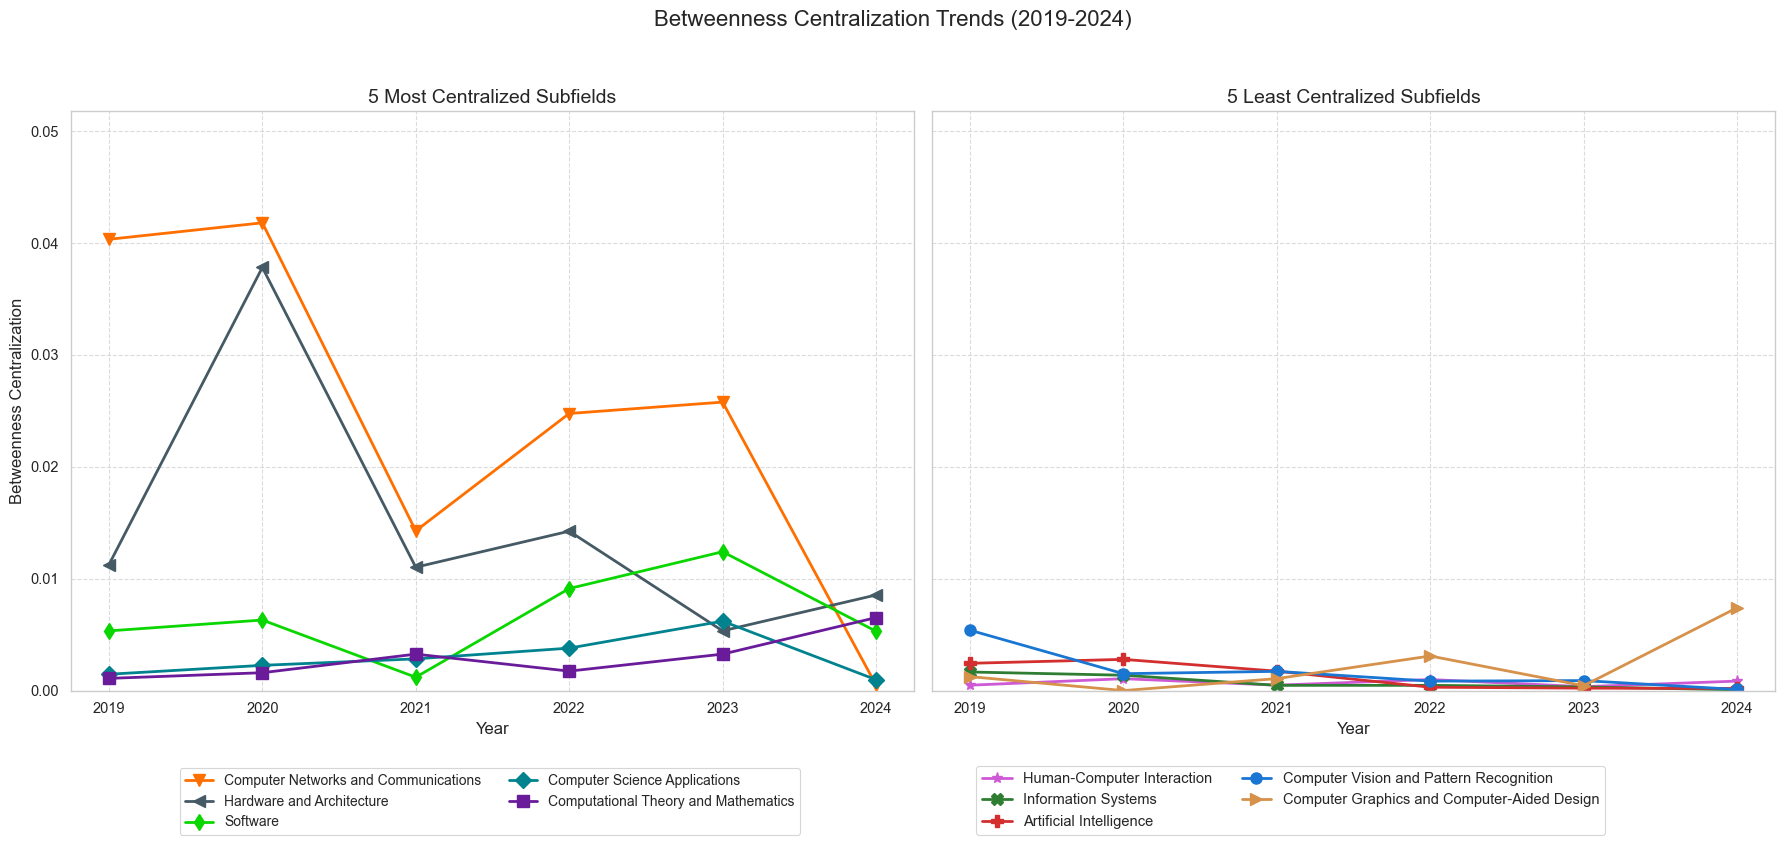

In [70]:
# Step 2: Create the visualizations
plot_centralization_comparison(centralization_df, YEARS)
plt.show()